# Not your grandmother’s toolbox– the Robotics Toolbox reinvented for python
### Peter Corke and Jesse Haviland

This is the code for the examples in the [paper published at ICRA2021](https://ieeexplore.ieee.org/document/9561366).


In [1]:
# !pip install numpy --upgrade
# !pip install roboticstoolbox-python
# !pip install -U ipython
from math import pi
import numpy as np
import matplotlib.pyplot as plt

# display result of assignments
%config ZMQInteractiveShell.ast_node_interactivity = 'last_expr_or_assign'
# make NumPy display a bit nicer
np.set_printoptions(linewidth=100, formatter={'float': lambda x: f"{x:10.4g}" if abs(x) > 1e-10 else f"{0:8.4g}"})
# make cells nice and wide
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))
# %matplotlib widget

# III.SPATIAL MATHEMATICS

The spatial math package underpins the Robotics and Machine Vision Toolboxes. It supports mathematical objects such as SO(2), SE(2), SO(3) and SE(3) matrices, quaternions and unit quaternions as well as twists in 2D and 3D.

We start by importing the package

In [2]:
from spatialmath.base import *

Now we can create an SE(3) transformation by composing a number of simple transformations such as translations and rotations.  These functions have the same names, and mimic the functions of the older Robotics Toolbox for MATLAB

In [3]:
T = transl(0.5, 0.0, 0.0) @ rpy2tr(0.1, 0.2, 0.3, order='xyz') @ trotx(-90, 'deg')

array([[    0.9752,    -0.1987,   -0.09784,        0.5],
       [    0.1538,     0.2896,     0.9447,        0],
       [   -0.1593,    -0.9363,      0.313,        0],
       [       0,        0,        0,          1]])

which has created a 4x4 NumPy array with an SE(3) matrix value.  There are lots of functions in `spatialmath.base` to convert between different representations such roll-pitch-yaw angles, Euler angles, angle-axis, unit quaternions and so on.  There are also functions to plot and animate frames and even turn those into mp4 files. If you're a fan of twists and product of exponential representations there are also functions to compute skew-symmetric matrices, logarithms and exponentials.

Alternatively, and definitely encouraged, we can use the object-oriented interface

In [4]:
from spatialmath import *

and we can rewrite the above example as

In [5]:
T = SE3(0.5, 0.0, 0.0) * SE3.RPY([0.1, 0.2, 0.3], order='xyz') * SE3.Rx(-90, unit='deg')

   0.9752   -0.1987   -0.09784   0.5       
   0.1538    0.2896    0.9447    0         
  -0.1593   -0.9363    0.313     0         
   0         0         0         1         


In most environments, we see the matrix printed with color coding: red for rotation submatrix, blue for translation, grey for constant values.

The matrices are encapsulated in objects, we can compose them using the regular `*` operator.  

In [6]:
T.eul()

array([     1.674,      1.252,     -1.402])

In [7]:
T.R

array([[    0.9752,    -0.1987,   -0.09784],
       [    0.1538,     0.2896,     0.9447],
       [   -0.1593,    -0.9363,      0.313]])

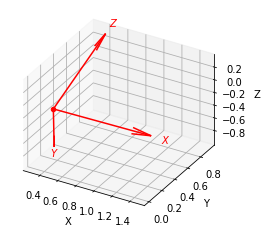

In [8]:
T.plot(color='red', label='2')

In [9]:
T.inv()

   0.9752    0.1538   -0.1593   -0.4876    
  -0.1987    0.2896   -0.9363    0.09933   
  -0.09784   0.9447    0.313     0.04892   
   0         0         0         1         


We can create unit quaternions using the same methods as we did for `SE3` objects, and compose them using the `*` operator

In [10]:
q1 = UnitQuaternion.Rx(0.3)


 0.9888 <<  0.1494,  0.0000,  0.0000 >>


In [11]:
q2 = UnitQuaternion.AngVec(0.3, [1, 0, 0])

 0.9888 <<  0.1494,  0.0000,  0.0000 >>


In [12]:
q3 = q1 * q2

 0.9553 <<  0.2955,  0.0000,  0.0000 >>


The inverse is easy

In [13]:
q3.inv()

 0.9553 << -0.2955, -0.0000, -0.0000 >>


and we can convert back to an SO(3) rotation matrix

In [14]:
q3.SO3()

   1         0         0         
   0         0.8253   -0.5646    
   0         0.5646    0.8253    


All the objects just introduced have three superpowers.  Firstly, they can each hold multiple values, just like a Python list.  This is really useful for a collection of frames along a trajectory, or for every link on a robot arm

In [15]:
T_many = SE3.Rx(np.linspace(0, pi/2, num=100))


0:
   1         0         0         0         
   0         1         0         0         
   0         0         1         0         
   0         0         0         1         
1:
   1         0         0         0         
   0         0.9999   -0.01587   0         
   0         0.01587   0.9999    0         
   0         0         0         1         
2:
   1         0         0         0         
   0         0.9995   -0.03173   0         
   0         0.03173   0.9995    0         
   0         0         0         1         
3:
   1         0         0         0         
   0         0.9989   -0.04758   0         
   0         0.04758   0.9989    0         
   0         0         0         1         
4:
   1         0         0         0         
   0         0.998    -0.06342   0         
   0         0.06342   0.998     0         
   0         0         0         1         
5:
   1         0         0         0         
   0         0.9969   -0.07925   0         
   0         0

In [16]:
len(T_many)

100

So we can slice them

In [17]:
T_many[20]

   1         0         0         0         
   0         0.9501   -0.312     0         
   0         0.312     0.9501    0         
   0         0         0         1         


or use them as iterators in `for` loop or comprehensions

In [18]:
for T in T_many:
    pass  # do a thing

The second super power is broadcasting.

In [19]:
T = SE3.Ry(60, unit="deg")
T2 = T_many * T
len(T2)

100

which has created a new `SE3` object where each value is `T_many[k] * T`.

The third superpower is all these objects can transform a vector, or a bunch of vectors

In [20]:
T * [1, 2, 3]

array([[     3.098],
       [         2],
       [     0.634]])

and the class has handled all the hassle of converting the vector to homogeneous form first.

This also works for a collection of vectors, always arranged columnwise

In [21]:
T * np.array([[1,2,3], [4,5,6]]).T

array([[     3.098,      7.196],
       [         2,          5],
       [     0.634,    -0.4641]])

and combining all the superpowers we can write

In [22]:
T_many * [1, 2, 3]

array([[         1,          1,          1,          1,          1,          1,          1,
                 1,          1,          1,          1,          1,          1,          1,
                 1,          1,          1,          1,          1,          1,          1,
                 1,          1,          1,          1,          1,          1,          1,
                 1,          1,          1,          1,          1,          1,          1,
                 1,          1,          1,          1,          1,          1,          1,
                 1,          1,          1,          1,          1,          1,          1,
                 1,          1,          1,          1,          1,          1,          1,
                 1,          1,          1,          1,          1,          1,          1,
                 1,          1,          1,          1,          1,          1,          1,
                 1,          1,          1,          1,          1,          1, 

which has applied each element of `T_many` to transform the vector `[1,2,3]`, resulting in a 3x100 array, one column per transformed vector.

# IV. ROBOTICS TOOLBOX
## A. Robot models

If you like Denavit-Hartenberg notation (standard or modified) then it is easy to create a robot model, it is simply a list of objects that represent a link-joint pair

In [23]:
from roboticstoolbox import *
# robot length values (metres)
d1 = 0.352
a1 = 0.070
a2 = 0.360
d4 = 0.380
d6 = 0.065;

In [24]:
robot = DHRobot([
  RevoluteDH(d=d1, a=a1, alpha=-pi/2), 
  RevoluteDH(a=a2), 
  RevoluteDH(alpha=pi/2),
  ], name="my IRB140")

DHRobot: my IRB140, 3 joints (RRR), dynamics, standard DH parameters
┌────┬───────┬──────┬────────┐
│θⱼ  │  dⱼ   │  aⱼ  │   ⍺ⱼ   │
├────┼───────┼──────┼────────┤
│ q1 │ 0.352 │ 0.07 │ -90.0° │
│ q2 │     0 │ 0.36 │   0.0° │
│ q3 │     0 │    0 │  90.0° │
└────┴───────┴──────┴────────┘

There are also a lot of prebuilt models shipping with the toolbox

In [25]:
models.list()

┌─────────────┬───────────────────────┬─────────────────────┬──────┬─────┬──────┬─────────────────────────────────┬──────────┬──────────┬──────────────────────────┐
│   class     │         name          │    manufacturer     │ type │ DoF │ dims │                       structure │ dynamics │ geometry │         keywords         │
├─────────────┼───────────────────────┼─────────────────────┼──────┼─────┼──────┼─────────────────────────────────┼──────────┼──────────┼──────────────────────────┤
│Panda        │ Panda                 │ Franka Emika        │ DH   │ 7   │ 3d   │ RRRRRRR                         │ Y        │ Y        │                          │
│Puma560      │ Puma 560              │ Unimation           │ DH   │ 6   │ 3d   │ RRRRRR                          │ Y        │ Y        │ dynamics, symbolic, mesh │
│Stanford     │ Stanford arm          │ Victor Scheinman    │ DH   │ 6   │ 3d   │ RRPRRR                          │ Y        │          │ dynamics                 │
│Ball     

There are currently over 50 robot models, and they fall into three types:
1. `DH`, based on standard or modifed Denavit-Hartenberg (DH) notation.  This is what you will find in most of the standard robotics texts
2. `ETS`, this is a new way to think about robot kinematics that avoids the (IMO) complexity of DH notation, and was described in [this paper](https://ieeexplore.ieee.org/document/4252158)
3. [`URDF`](http://wiki.ros.org/urdf/Tutorials/Building%20a%20Visual%20Robot%20Model%20with%20URDF%20from%20Scratch), which is an industry standard way to represent kinematics, dynamics and 3D structure in XML format

We will load a standard Denavit-Hartenberg model of Peter's favourite robot

In [26]:
puma = models.DH.Puma560()

DHRobot: Puma 560 (by Unimation), 6 joints (RRRRRR), dynamics, geometry, standard DH parameters
┌────┬────────┬────────┬────────┬─────────┬────────┐
│θⱼ  │   dⱼ   │   aⱼ   │   ⍺ⱼ   │   q⁻    │   q⁺   │
├────┼────────┼────────┼────────┼─────────┼────────┤
│ q1 │ 0.6718 │      0 │  90.0° │ -160.0° │ 160.0° │
│ q2 │      0 │ 0.4318 │   0.0° │ -110.0° │ 110.0° │
│ q3 │   0.15 │ 0.0203 │ -90.0° │ -135.0° │ 135.0° │
│ q4 │ 0.4318 │      0 │  90.0° │ -266.0° │ 266.0° │
│ q5 │      0 │      0 │ -90.0° │ -100.0° │ 100.0° │
│ q6 │      0 │      0 │   0.0° │ -266.0° │ 266.0° │
└────┴────────┴────────┴────────┴─────────┴────────┘

┌─────┬─────┬──────┬───────┬─────┬──────┬─────┐
│name │ q0  │ q1   │ q2    │ q3  │ q4   │ q5  │
├─────┼─────┼──────┼───────┼─────┼──────┼─────┤
│  qz │  0° │  0°  │  0°   │  0° │  0°  │  0° │
│  qr │  0° │  90° │ -90°  │  0° │  0°  │  0° │
│  qs │  0° │  0°  │ -90°  │  0° │  0°  │  0° │
│  qn │  0° │  45° │  180° │  0° │  45° │  0° │
└─────┴─────┴──────┴───────┴─────┴───

The `__repr__` method for these objects pretty prints the parameters as a table.  The second table is a list of named joint configurations, for example the "nominal" configuration is

In [27]:
puma.qn

array([0.        , 0.78539816, 3.14159265, 0.        , 0.78539816, 0.        ])

You can easily add your own, which modifies that particular robot instance

In [28]:
puma.addconfiguration("foo", [1,2,3,4,5,6])
puma.foo

array([1., 2., 3., 4., 5., 6.])

The most fundamental operation on a robot is to determine its forward kinematics, that is, the pose of its end effector given the joint configuration.  All types of robot object have an `fkine` method to compute this

In [29]:
T = puma.fkine([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

   0.1217   -0.6067   -0.7856    0.2478    
   0.8184    0.5092   -0.2665   -0.1259    
   0.5617   -0.6105    0.5584    1.146     
   0         0         0         1         


or, if you prefer, in a more compact form

In [30]:
T.printline()

t = 0.248, -0.126, 1.15; rpy/zyx = -47.5°, -34.2°, 81.5°


The next most fundamental operation on a robot is to determine its inverse kinematics, that is, given the pose of its end effector, what are the required joint angles.  In general there are multiple solutions, and the Toolbox provides a numerical solution to this problem

In [31]:
sol = puma.ikine_LM(T)

IKsolution(q=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), success=True, reason=None, iterations=12, residual=8.515092622288915e-13)

and the return value indicates success and provides the required joint angles.

Because this is a numerical solution, it requires a reasonable initial estimate of the joint configuration.  Here it started at zero and has managed to converge, but if it does not converge then a better initial estimate is required, provided using the `q0=` argument.

Some robots, for example the Puma560, have an analytical solution available as well, and its options allow for control over which, of the multiple, solutions is returned

In [32]:
puma.ikine_a(T)

IKsolution(q=array([ 2.10117673,  1.11634865,  0.3       ,  0.9527867 , -1.65052534, -0.9859752 ]), success=True, reason='')

We can also plot the robot, but this seems to be not working in Jupyter :()

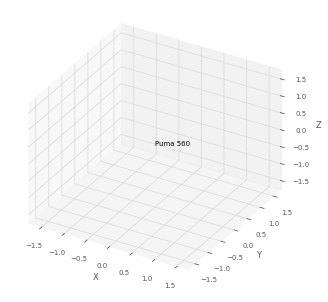

<Figure size 432x288 with 0 Axes>

In [33]:
puma.plot(sol.q, backend="pyplot");

In [34]:
puma.ikine_a(T, config="lun")

IKsolution(q=array([ 2.10117673,  1.11634865,  0.3       ,  0.9527867 , -1.65052534, -0.9859752 ]), success=True, reason='')

As mentioned earlier, the ETS notation is a different way to think about robot kinematics.

We start by defining a set of dimensions for the robot, this example mimics the one in the [paper](https://ieeexplore.ieee.org/document/4252158)

In [35]:
from roboticstoolbox import ETS as ET
# Puma dimensions (m), see RVC2 Fig. 7.4 for details
l1 = 0.672
l2 = -0.2337
l3 = 0.4318
l4 = 0.0203
l5 = 0.0837
l6 = 0.4318;

and now we can write an expression, in terms of translations and rotations, along or about the x-, y- and z-axes.  These can be by a constant amount or by a joint variable (indicated by no passed argument to the method)

In [36]:
e = ET.tz(l1) * ET.rz() * ET.ty(l2) * ET.ry() \
    * ET.tz(l3) * ET.tx(l4) * ET.ty(l5) * ET.ry() \
    * ET.tz(l6) * ET.rz() * ET.ry() * ET.rz()

tz(0.672) ⊕ Rz(q0) ⊕ ty(-0.2337) ⊕ Ry(q1) ⊕ tz(0.4318) ⊕ tx(0.0203) ⊕ ty(0.0837) ⊕ Ry(q2) ⊕ tz(0.4318) ⊕ Rz(q3) ⊕ Ry(q4) ⊕ Rz(q5)

The result is an `ETS` object which is like a Python list, it can sliced and iterated.

We pass this to the `ERobot` constructor (E for ETS robot) and it chops the ETS into chunks, each one ending with a joint variable

In [37]:
robot = ERobot(e)

ERobot: noname, 6 joints (RRRRRR)
┌───┬────────┬───────┬────────┬───────────────────────────────────────────────────────────────────┐
│id │  link  │ joint │ parent │                                ETS                                │
├───┼────────┼───────┼────────┼───────────────────────────────────────────────────────────────────┤
│ 1 │ link0  │     0 │ BASE   │ {link0} = {BASE} ⊕ tz(0.672) ⊕ Rz(q0)                             │
│ 2 │ link1  │     1 │ link0  │ {link1} = {link0} ⊕ ty(-0.2337) ⊕ Ry(q1)                          │
│ 3 │ link2  │     2 │ link1  │ {link2} = {link1} ⊕ tz(0.4318) ⊕ tx(0.0203) ⊕ ty(0.0837) ⊕ Ry(q2) │
│ 4 │ link3  │     3 │ link2  │ {link3} = {link2} ⊕ tz(0.4318) ⊕ Rz(q3)                           │
│ 5 │ link4  │     4 │ link3  │ {link4} = {link3} ⊕ Ry(q4)                                        │
│ 6 │ @link5 │     5 │ link4  │ {link5} = {link4} ⊕ Rz(q5)                                        │
└───┴────────┴───────┴────────┴───────────────────────────────────

The `@` symbol indicates the end of a branch (we can have robots with multiple branches) or an end-effector.

Finally, we will load a model of the Franka-Emika Panda from a URDF file that is included with the Toolbox

In [38]:
panda = models.URDF.Panda()

ERobot: panda (by Franka Emika), 7 joints (RRRRRRR), geometry, collision
┌───┬──────────────┬───────┬─────────────┬─────────────────────────────────────────────────────────────────────────────┐
│id │     link     │ joint │   parent    │                                     ETS                                     │
├───┼──────────────┼───────┼─────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ 1 │ panda_link0  │       │ BASE        │ {panda_link0} = {BASE}                                                      │
│ 2 │ panda_link1  │     0 │ panda_link0 │ {panda_link1} = {panda_link0} ⊕ tz(0.333) ⊕ Rz(q0)                          │
│ 3 │ panda_link2  │     1 │ panda_link1 │ {panda_link2} = {panda_link1} ⊕ Rx(-90°) ⊕ Rz(q1)                           │
│ 4 │ panda_link3  │     2 │ panda_link2 │ {panda_link3} = {panda_link2} ⊕ ty(-0.316) ⊕ Rx(90°) ⊕ Rz(q2)               │
│ 5 │ panda_link4  │     3 │ panda_link3 │ {panda_link4} = {panda_link3} ⊕ tx(0.

The table at the top has tags:
* `geometry` the model includes models of the 3D geometry of the robot, as STL or Collada files.
* `collision` the model includes collision geometry, a set of simple geometric primitives, such as cylinders and spheres, for each link that can be used for collision checking.

The `@` symbol again indicates the end of a branch (we can have robots with multiple branches) or an end-effector.  Links shown in blue have a constant transformation with respect to their parent link.


## B. Trajectories

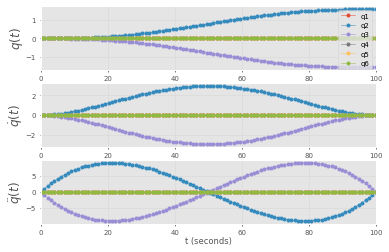

In [39]:
traj = jtraj(puma.qz, puma.qr, 100)
traj.plot(block=True)

In [40]:
t = np.arange(0, 2, 0.010)
T0 = SE3(0.6, -0.5, 0.3)

   1         0         0         0.6       
   0         1         0        -0.5       
   0         0         1         0.3       
   0         0         0         1         


In [41]:
T1 = SE3(0.4, 0.5, 0.2)

   1         0         0         0.4       
   0         1         0         0.5       
   0         0         1         0.2       
   0         0         0         1         


In [42]:
Ts = ctraj(T0, T1, t)
len(Ts)

200

In [43]:
sol = puma.ikine_LM(Ts)
sol.q.shape

## C. Symbolic manipulation

In [ ]:
# !pip install sympy
import spatialmath.base.symbolic as sym

We first define some symbols, these are Python objects.  We can give them unicode names so that they display as Greek letters.  Now we can display the mapping from roll-pitch-yaw angles to an SO(3) matrix.

In [ ]:
phi, theta, psi = sym.symbol('φ, ϴ, ψ')
rpy2r(phi, theta, psi)

Next, we can define a vector of symbolic joint variables, and use that to compute the forward kinematics -- symbolically.

In [ ]:
q = sym.symbol("q_:6") # q = (q_1, q_2, ... q_5)
T = puma.fkine(q);

This expression is huge, remove the semicolon on the last line above, and rerun the cell to check.

Partly this is because $\alpha_j$ values, which are generally some integer multiple of $\pi/2$, lead to sin and cos values that are not quite zero or one.

Instead we can load a new model of the robot where those parameters have symbolic values, not numeric, leading to crisp zero or one trig results.

In [ ]:
puma = models.DH.Puma560(symbolic=True)
T = puma.fkine(q)

The result is much more compact.  Here, we will display just the translational part of this.  The position of the end effector as a function of the first three joint angles.  The last three joint angles don't enter because the robot has a spherical wrist and the tool in this example has zero length.

In [ ]:
T.t[0]

## D. Differential kinematics

We will reload the numerical robot model

In [ ]:
puma = models.DH.Puma560(symbolic=False)

Now we will compute the Jacobian matrix that relates joint velocity to spatial velocity of the end effector, in the world-coordinate frame

In [ ]:
J = puma.jacob0(puma.qr)

This particular configuration is singular, and the Jacobian is not full rank

In [ ]:
np.linalg.matrix_rank(J)

Analyzing dependencies amongst the columns of the Jacobians we find that

In [ ]:
jsingu(J)

We can just as easily compute the Jacobian in the end effector coordinate frame

In [ ]:
J = puma.jacobe(puma.qn)

The Hessian is the derivative of the Jacobian and is a rank-3 tensor, a 3D array, useful in task-space dynamic problems

In [ ]:
H = puma.hessian0(puma.qn)
H.shape

For many robot problems we are interested in manipulability, that is, how well posed the robot is to make movement in any direction.  We can also think of this as distance away from a singularity where we lose a degree of freedom of motion.  Two common measures are due to Yoshikawa and Asada

In [ ]:
puma.manipulability(puma.qn)

In [ ]:
puma.manipulability(puma.qn, method="asada")

In [ ]:
puma.manipulability(puma.qn, axes="trans")

Motion control that optimizes manipulability needs the manipulability Jacobian, the rate of change of manipulability with respect to each joint variable

In [ ]:
puma.jacobm(puma.qn)

## E. Dynamics

The Toolbox has rich support for manipulator dynamics.

We can compute the inverse dynamics, the torques required to achieve a particular dynamic state $(q, \dot{q}, \ddot{q})$

In [ ]:
tau = puma.rne(puma.qn, np.zeros((6,)), np.zeros((6,)))

The inertia tensor is a symmetric matrix that depends on joint configuration

In [ ]:
J = puma.inertia(puma.qn)

and the velocity terms, Coriolis and centrigual coupling terms, is a function of joint configuration and velocity

In [ ]:
C = puma.coriolis(puma.qn, 0.1 * np.ones((6,)))

The final element is the gravity torque, the joint torques due to gravity weight forces acting on all the links

In [ ]:
g = puma.gravload(puma.qn)

The forward dynamics is the joint acceleration as a function of $(q, \dot{q}, \tau)$ and can be integrated to simulate the motion of the robot.

In [ ]:
qdd = puma.accel(puma.qn, np.zeros((6,)), tau)

# V. NEW CAPABILITY
## B. Collision checking

In [ ]:
!pip install spatialgeometry
from spatialgeometry import Cuboid


The Toolbox now has support for collision checking, using the bullet engine.

We create an instance of a Franka-Emika Panda robot and a big box, 1x1x1m 

In [ ]:
panda = models.URDF.Panda()
obstacle = Cuboid([1, 1, 1], base=SE3(1, 0, 0));

And then test if the robot, in configuration `qr`, collides with the box

In [ ]:
iscollision = panda.collided(panda.qr, obstacle) # boolean

which it does.  We can do more fine grained testing, does link[0] collide with the box?

In [ ]:
iscollision = panda.links[0].collided(obstacle)

No, it doesn't.  But what are the closest points on these objects  

In [ ]:

d, p1, p2 = panda.links[0].closest_point(obstacle)
print(d, p1, p2)

where `d` is the distance, 0.5m, and `p1` is a point on the robot link 0 and `p2` is a point on the box

## C. Interfaces

The examples below will not work with CoLab.  They require a local browser to display the robot.

To display the robot at a particular configuration

In [ ]:
panda.plot(panda.qr, block=False);

To animate the robot within the browser tab, we create a Swift instance, add the robot

In [ ]:
from roboticstoolbox.backends.swift import Swift
import time
qt = jtraj(panda.qz, panda.qr, 100)
backend = Swift()
backend.launch()   # create graphical world
backend.add(panda) # add robot to the world
for q in qt.q:
    panda.q = q        # update the robot
    backend.step(0.2)    # display the world
    time.sleep(0.1)


In [ ]:
qt.q.shape